In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [3]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


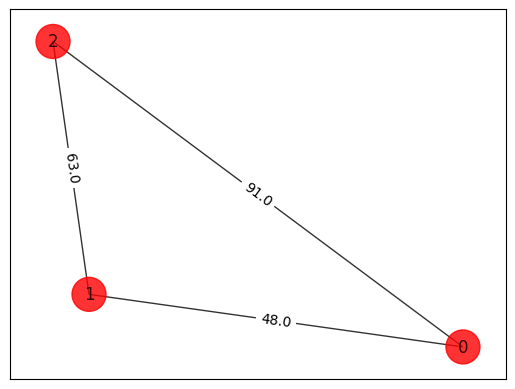

In [4]:
# Generating a graph of 3 nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [5]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [6]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 7581.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-1282.5 +0.j, -1282.5 +0.j, -1282.5 +0.j, -1268.5 +0.j, -1268.5 +0.j,
 -1268.5 +0.j, -1290.  +0.j, -1290.  +0.j, -1290.  +0.j,   606.5 +0.j,
   606.5 +0.j,   606.5 +0.j,    12.  +0.j,    12.  +0.j,   606.5 +0.j,
    22.75+0.j,    22.75+0.j,   606.5 +0.j,    12.  +0.j,   606.5 +0.j,
    12.  +0.j,    22.75+0.j,   606.5 +0.j,    22.75+0.j,    

In [8]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())

In [9]:
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 202.0
variable values: x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0
status: SUCCESS


In [11]:
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

energy: -7379.0
tsp objective: 202.0
feasible: True
solution: [0, 1, 2]
solution objective: 202.0


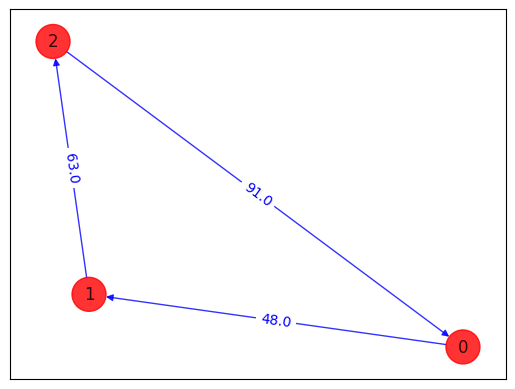

In [12]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

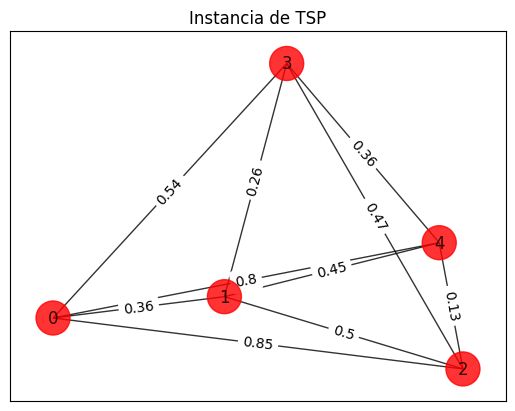

KeyboardInterrupt: 

In [24]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import permutations
import random

# --- 1. Crear instancia aleatoria de TSP con 3 ciudades ---
n_cities = 5
random.seed(123)
positions = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(n_cities)}
G = nx.complete_graph(n_cities)

for i in G.nodes:
    G.nodes[i]["pos"] = positions[i]

for i, j in G.edges:
    xi, yi = positions[i]
    xj, yj = positions[j]
    distance = np.round(np.sqrt((xi - xj) ** 2 + (yi - yj) ** 2), 2)
    G[i][j]["weight"] = distance

pos = nx.get_node_attributes(G, 'pos')
colors = ["r" for _ in G.nodes]

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)
plt.title("Instancia de TSP")
plt.show()

# --- 2. Crear matriz de distancias ---
distance_matrix = nx.to_numpy_array(G)

# --- 3. QUBO para el TSP ---

def tsp_cost(bitstring, distance_matrix):
    n = len(distance_matrix)
    path = []

    for t in range(n):
        for i in range(n):
            if bitstring[t * n + i] == 1:
                path.append(i)
                break

    total = 0
    for i in range(len(path)):
        total += distance_matrix[path[i]][path[(i + 1) % n]]

    return total

# --- 4. Circuito QAOA en PennyLane ---
n_qubits = n_cities ** 2
dev = qml.device("default.qubit", wires=n_qubits)

def cost_layer(gamma):
    for i in range(n_cities):
        for j in range(n_cities):
            if i != j:
                for t in range(n_cities - 1):
                    q1 = t * n_cities + i
                    q2 = (t + 1) * n_cities + j
                    w = distance_matrix[i][j]
                    qml.MultiRZ(2 * gamma * w, wires=[q1, q2])

def mixer_layer(beta):
    for i in range(n_qubits):
        qml.RX(2 * beta, wires=i)

def qaoa_layer(gamma, beta):
    cost_layer(gamma)
    mixer_layer(beta)

@qml.qnode(dev)
def circuit(params):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    for gamma, beta in params:
        qaoa_layer(gamma, beta)
    return qml.probs(wires=range(n_qubits))

# --- 5. Optimización ---
def sample_most_likely(probabilities):
    idx = np.argmax(probabilities)
    bitstring = np.binary_repr(idx, width=n_qubits)
    return np.array([int(x) for x in bitstring])

def is_valid_tour(bitstring):
    for t in range(n_cities):
        if sum(bitstring[t * n_cities:(t + 1) * n_cities]) != 1:
            return False
    for i in range(n_cities):
        if sum([bitstring[i + t * n_cities] for t in range(n_cities)]) != 1:
            return False
    return True

def objective_fn(params):
    probs = circuit(params)
    cost = 0
    for i in range(len(probs)):
        bitstring = np.array([int(x) for x in np.binary_repr(i, width=n_qubits)])
        if is_valid_tour(bitstring):
            cost += probs[i] * tsp_cost(bitstring, distance_matrix)
        else:
            cost += probs[i] * 1e6  # penalizar soluciones inválidas
    return cost

# --- 6. Ejecutar optimización ---
np.random.seed(42)
p = 2
init_params = 0.01 * np.random.randn(p, 2)
opt = qml.GradientDescentOptimizer(stepsize=0.4)
steps = 100

params = init_params
for i in range(steps):
    params = opt.step(objective_fn, params)
    if i % 10 == 0:
        print(f"Step {i}: cost = {objective_fn(params)}")

# --- 7. Mostrar mejor solución ---
probs = circuit(params)
solution_bitstring = sample_most_likely(probs)

if is_valid_tour(solution_bitstring):
    print("✅ Valid tour found.")
    path = []
    for t in range(n_cities):
        for i in range(n_cities):
            if solution_bitstring[t * n_cities + i] == 1:
                path.append(i)
                break
    print("Path:", path)
    print("Tour length:", tsp_cost(solution_bitstring, distance_matrix))
else:
    print("❌ No valid tour found.")

# --- 8. Graficar solución ---
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

draw_tsp_solution(G, path, colors, pos)
plt.title("Solución del TSP encontrada con PennyLane")
plt.show()


In [ ]:
algorithm_globals.random_seed = 123
seed = 10598

Distance matrix:
 [[0.  6.4 8.5 3.7 6.5]
 [6.4 0.  2.9 5.7 2.3]
 [8.5 2.9 0.  4.9 3.6]
 [3.7 5.7 4.9 0.  4.3]
 [6.5 2.3 3.6 4.3 0. ]]


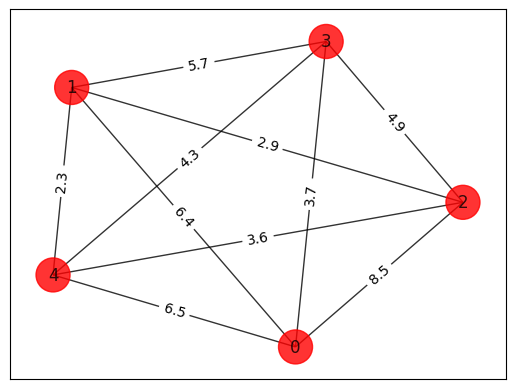

DecompositionUndefinedError: 

In [25]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# ----- PARAMETROS DEL PROBLEMA -----
n = 5
num_qubits = n * n
A = 100  # penalización para restricciones

# ----- GRAFO ALEATORIO -----
G = nx.complete_graph(n)
pos = nx.spring_layout(G, seed=123)
for i in G.nodes():
    for j in G.nodes():
        if i != j:
            G[i][j]["weight"] = float(np.round(np.random.uniform(1, 10), 1))

adj_matrix = nx.to_numpy_array(G)
print("Distance matrix:\n", adj_matrix)

# ----- DIBUJAR EL GRAFO -----
colors = ["r"] * n
def draw_graph(G, colors, pos):
    plt.figure()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    plt.show()

draw_graph(G, colors, pos)

# ----- HAMILTONIANO TSP -----
def tsp_hamiltonian(n, adj_matrix, A):
    coeffs = []
    ops = []

    # Restricción: cada ciudad una vez
    for i in range(n):
        for j in range(n):
            for k in range(j + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(i * n + k))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    # Restricción: cada posición una vez
    for j in range(n):
        for i in range(n):
            for k in range(i + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(k * n + j))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    # Función objetivo (distancias)
    for i in range(n):
        for j in range(n):
            if i != j:
                for t in range(n):
                    u = i * n + t
                    v = j * n + ((t + 1) % n)
                    d = float(adj_matrix[i][j]) / 4
                    coeffs += [d, -d, -d]
                    ops += [
                        qml.PauliZ(u) @ qml.PauliZ(v),
                        qml.PauliZ(u),
                        qml.PauliZ(v)
                    ]

    return qml.Hamiltonian(coeffs, ops)

H = tsp_hamiltonian(n, adj_matrix, A)

# ----- CONSTRUIR MATRIZ Y DIAGONALIZAR -----
dev = qml.device("default.qubit", wires=num_qubits)
H_mat = qml.matrix(H, wire_order=list(range(num_qubits)))

eigenvalues, eigenvectors = eigh(H_mat)
min_energy = eigenvalues[0]
ground_state = eigenvectors[:, 0]
print("Minimum energy:", min_energy)

# ----- OBTENER SOLUCIÓN BINARIA -----
def sample_most_likely(state_vector):
    probs = np.abs(state_vector) ** 2
    index = np.argmax(probs)
    bin_string = bin(index)[2:].zfill(num_qubits)
    return np.array([int(bit) for bit in bin_string])

x = sample_most_likely(ground_state)
print("Bitstring solution:", x)

# ----- INTERPRETAR RUTA -----
def interpret_solution(x):
    order = [-1] * n
    for i in range(n):
        for j in range(n):
            if x[i * n + j] == 1:
                order[j] = i
    return order

order = interpret_solution(x)
print("Visit order:", order)

# ----- DIBUJAR RUTA -----
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    for i in range(len(order)):
        j = (i + 1) % len(order)
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    plt.figure()
    nx.draw_networkx(G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)
    plt.show()

draw_tsp_solution(G, order, colors, pos)


Distance matrix:
 [[0.  1.1 3.  9.5]
 [1.1 0.  2.1 3.9]
 [3.  2.1 0.  5.7]
 [9.5 3.9 5.7 0. ]]


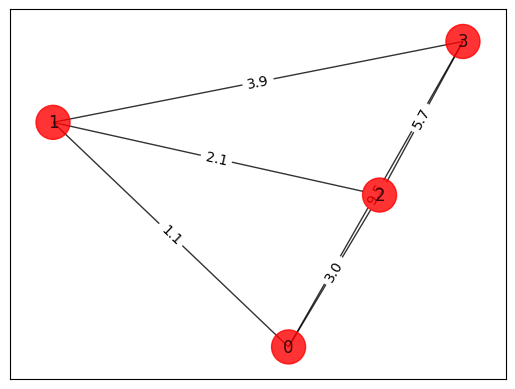

🔄 Optimizing QAOA parameters...
✅ Optimization complete.
🔎 Buscando la mejor ruta entre 1000 mediciones...
✅ Mejor ruta válida encontrada: (0, 2, 3, 1)


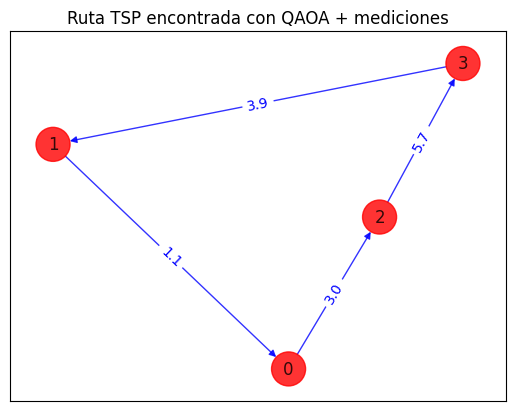

In [32]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from collections import Counter

# -------- PARÁMETROS --------
n = 4
num_qubits = n * n
p = 2
A = 100

# -------- GRAFO ALEATORIO --------
G = nx.complete_graph(n)
pos = nx.spring_layout(G, seed=123)
for i in G.nodes():
    for j in G.nodes():
        if i != j:
            G[i][j]["weight"] = float(np.round(np.random.uniform(1, 10), 1))

adj_matrix = nx.to_numpy_array(G)
print("Distance matrix:\n", adj_matrix)

def draw_graph(G, colors, pos):
    plt.figure()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    plt.show()

draw_graph(G, ["r"] * n, pos)

# -------- HAMILTONIANO TSP --------
def tsp_hamiltonian(n, adj_matrix, A):
    coeffs = []
    ops = []

    for i in range(n):
        for j in range(n):
            for k in range(j + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(i * n + k))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    for j in range(n):
        for i in range(n):
            for k in range(i + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(k * n + j))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    for i in range(n):
        for j in range(n):
            if i != j:
                for t in range(n):
                    u = i * n + t
                    v = j * n + ((t + 1) % n)
                    d = float(adj_matrix[i][j]) / 4
                    coeffs += [d, -d, -d]
                    ops += [
                        qml.PauliZ(u) @ qml.PauliZ(v),
                        qml.PauliZ(u),
                        qml.PauliZ(v)
                    ]

    return qml.Hamiltonian(coeffs, ops)

H = tsp_hamiltonian(n, adj_matrix, A)

# -------- QAOA MANUAL + SIMULADOR CON SHOTS --------
dev = qml.device("default.qubit", wires=num_qubits, shots=1000)

@qml.qnode(dev)
def qaoa_circuit(params):
    gammas, betas = params
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
    for i in range(p):
        qml.ApproxTimeEvolution(H, gammas[i], 1)
        for wire in range(num_qubits):
            qml.RX(2 * betas[i], wires=wire)
    return qml.expval(H)

# -------- OPTIMIZACIÓN --------
init_params = np.random.uniform(0, np.pi, (2, p))
init_params_flat = init_params.flatten()

def cost_fn_flat(params_flat):
    params = params_flat.reshape((2, p))
    return qaoa_circuit(params)

print("🔄 Optimizing QAOA parameters...")
opt_result = minimize(cost_fn_flat, x0=init_params_flat, method="COBYLA", options={"maxiter": 100})
opt_params = opt_result.x.reshape((2, p))
print("✅ Optimization complete.")

# -------- MEDICIONES CON SAMPLE --------
@qml.qnode(dev)
def sample_final(params):
    gammas, betas = params
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
    for i in range(p):
        qml.ApproxTimeEvolution(H, gammas[i], 1)
        for wire in range(num_qubits):
            qml.RX(2 * betas[i], wires=wire)
    return qml.sample(wires=range(num_qubits))

samples = sample_final(opt_params)

# -------- FUNCIONES DE INTERPRETACIÓN --------
def interpret_and_validate(x, n):
    order = [-1] * n
    for i in range(n):
        for j in range(n):
            if x[i * n + j] == 1:
                order[j] = i
    valid = sorted(order) == list(range(n))
    return tuple(order), valid

# -------- BUSCAR SOLUCIÓN MÁS FRECUENTE Y VÁLIDA --------
print("🔎 Buscando la mejor ruta entre 1000 mediciones...")
bitstrings = [tuple(sample.tolist()) for sample in samples]
valid_orders = []

for bit in bitstrings:
    order, valid = interpret_and_validate(np.array(bit), n)
    if valid:
        valid_orders.append(order)

if valid_orders:
    most_common_order = Counter(valid_orders).most_common(1)[0][0]
    print("✅ Mejor ruta válida encontrada:", most_common_order)
    
    def draw_tsp_solution(G, order, colors, pos):
        G2 = nx.DiGraph()
        G2.add_nodes_from(G)
        for i in range(len(order)):
            j = (i + 1) % len(order)
            if order[i] in G and order[j] in G[order[i]]:
                G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
        plt.figure()
        nx.draw_networkx(G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, pos=pos)
        edge_labels = nx.get_edge_attributes(G2, "weight")
        nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)
        plt.title("Ruta TSP encontrada con QAOA + mediciones")
        plt.show()

    draw_tsp_solution(G, most_common_order, ["r"] * n, pos)

else:
    print("❌ No se encontró ninguna ruta válida en las 1000 mediciones.")


Distance matrix:
 [[  0. 245. 302. 707.]
 [245.   0. 328. 531.]
 [302. 328.   0. 856.]
 [707. 531. 856.   0.]]


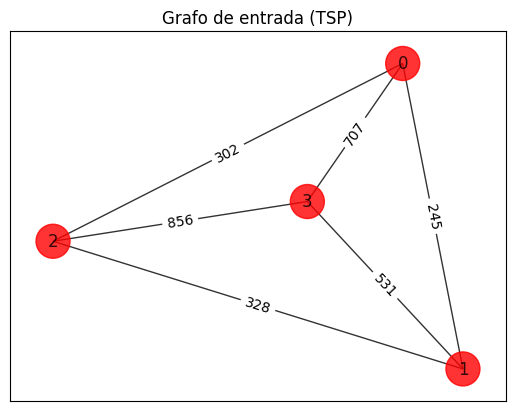

🔄 Optimizing QAOA parameters...
✅ Optimization complete.
🔎 Buscando la mejor ruta entre 1000 mediciones...
✅ Mejor ruta válida encontrada: (1, 2, 0, 3)


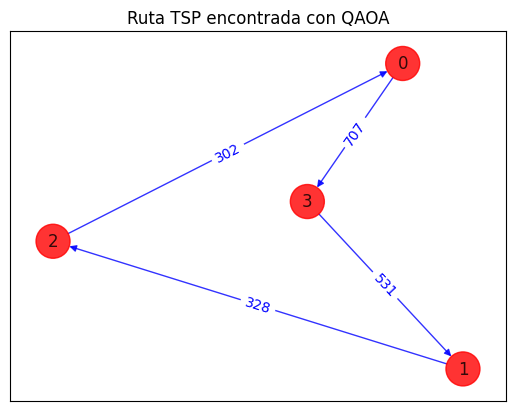

In [33]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from collections import Counter

# -------- PARÁMETROS --------
n = 4
num_qubits = n * n
p = 2
A = 100

# -------- GRAFO PERSONALIZADO --------
edges = [(0, 1, 245), (0, 2, 302), (0, 3, 707), (1, 2, 328), (1, 3, 531), (2, 3, 856)]
G = nx.Graph()
G.add_weighted_edges_from(edges)
pos = nx.spring_layout(G, seed=42)

adj_matrix = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
print("Distance matrix:\n", adj_matrix)

def draw_graph(G, colors, pos):
    plt.figure()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    plt.title("Grafo de entrada (TSP)")
    plt.show()

draw_graph(G, ["r"] * n, pos)

# -------- HAMILTONIANO TSP --------
def tsp_hamiltonian(n, adj_matrix, A):
    coeffs = []
    ops = []

    for i in range(n):
        for j in range(n):
            for k in range(j + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(i * n + k))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    for j in range(n):
        for i in range(n):
            for k in range(i + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(k * n + j))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    for i in range(n):
        for j in range(n):
            if i != j:
                for t in range(n):
                    u = i * n + t
                    v = j * n + ((t + 1) % n)
                    d = float(adj_matrix[i][j]) / 4
                    coeffs += [d, -d, -d]
                    ops += [
                        qml.PauliZ(u) @ qml.PauliZ(v),
                        qml.PauliZ(u),
                        qml.PauliZ(v)
                    ]

    return qml.Hamiltonian(coeffs, ops)

H = tsp_hamiltonian(n, adj_matrix, A)

# -------- QAOA CON MEDICIÓN --------
dev = qml.device("default.qubit", wires=num_qubits, shots=1000)

@qml.qnode(dev)
def qaoa_circuit(params):
    gammas, betas = params
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
    for i in range(p):
        qml.ApproxTimeEvolution(H, gammas[i], 1)
        for wire in range(num_qubits):
            qml.RX(2 * betas[i], wires=wire)
    return qml.expval(H)

# -------- OPTIMIZACIÓN --------
init_params = np.random.uniform(0, np.pi, (2, p))
init_params_flat = init_params.flatten()

def cost_fn_flat(params_flat):
    params = params_flat.reshape((2, p))
    return qaoa_circuit(params)

print("🔄 Optimizing QAOA parameters...")
opt_result = minimize(cost_fn_flat, x0=init_params_flat, method="COBYLA", options={"maxiter": 100})
opt_params = opt_result.x.reshape((2, p))
print("✅ Optimization complete.")

# -------- MEDICIONES CON SAMPLE --------
@qml.qnode(dev)
def sample_final(params):
    gammas, betas = params
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
    for i in range(p):
        qml.ApproxTimeEvolution(H, gammas[i], 1)
        for wire in range(num_qubits):
            qml.RX(2 * betas[i], wires=wire)
    return qml.sample(wires=range(num_qubits))

samples = sample_final(opt_params)

# -------- FUNCIONES AUXILIARES --------
def interpret_and_validate(x, n):
    order = [-1] * n
    for i in range(n):
        for j in range(n):
            if x[i * n + j] == 1:
                order[j] = i
    valid = sorted(order) == list(range(n))
    return tuple(order), valid

# -------- FILTRAR Y GRAFICAR --------
print("🔎 Buscando la mejor ruta entre 1000 mediciones...")
bitstrings = [tuple(sample.tolist()) for sample in samples]
valid_orders = []

for bit in bitstrings:
    order, valid = interpret_and_validate(np.array(bit), n)
    if valid:
        valid_orders.append(order)

if valid_orders:
    most_common_order = Counter(valid_orders).most_common(1)[0][0]
    print("✅ Mejor ruta válida encontrada:", most_common_order)

    def draw_tsp_solution(G, order, colors, pos):
        G2 = nx.DiGraph()
        G2.add_nodes_from(G)
        for i in range(len(order)):
            j = (i + 1) % len(order)
            if order[i] in G and order[j] in G[order[i]]:
                G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
        plt.figure()
        nx.draw_networkx(G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, pos=pos)
        edge_labels = nx.get_edge_attributes(G2, "weight")
        nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)
        plt.title("Ruta TSP encontrada con QAOA")
        plt.show()

    draw_tsp_solution(G, most_common_order, ["r"] * n, pos)

else:
    print("❌ No se encontró ninguna ruta válida en las 1000 mediciones.")


In [1]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from collections import Counter

Distance matrix:
 [[  0. 245. 302. 707.]
 [245.   0. 328. 531.]
 [302. 328.   0. 856.]
 [707. 531. 856.   0.]]


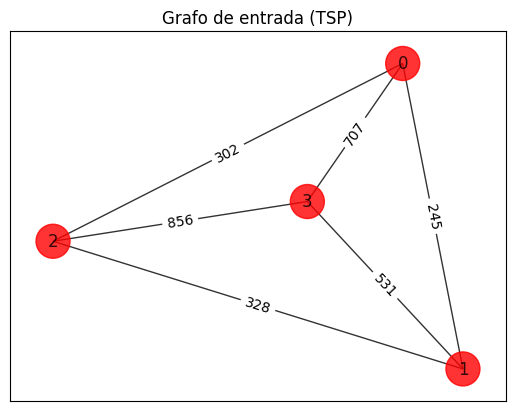

🔄 Optimizing QAOA parameters...
✅ Optimization complete.
🔎 Buscando la mejor ruta entre 1000 mediciones...
✅ Mejor ruta válida encontrada: (1, 3, 2, 0)


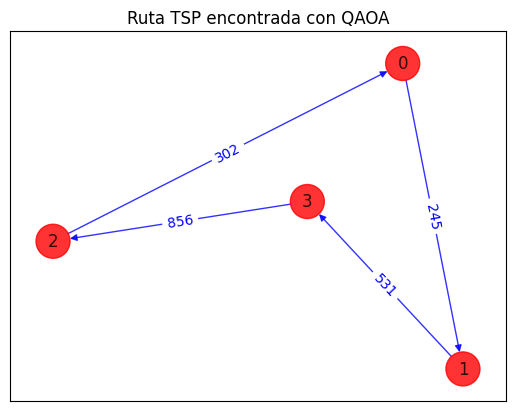

In [2]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from collections import Counter

# -------- PARÁMETROS --------
n = 4
num_qubits = n * n
p = 2
A = 100

# -------- GRAFO PERSONALIZADO --------
edges = [(0, 1, 245), (0, 2, 302), (0, 3, 707), (1, 2, 328), (1, 3, 531), (2, 3, 856)]
G = nx.Graph()
G.add_weighted_edges_from(edges)
pos = nx.spring_layout(G, seed=42)

adj_matrix = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
print("Distance matrix:\n", adj_matrix)

def draw_graph(G, colors, pos):
    plt.figure()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    plt.title("Grafo de entrada (TSP)")
    plt.show()

draw_graph(G, ["r"] * n, pos)

# -------- HAMILTONIANO TSP --------
def tsp_hamiltonian(n, adj_matrix, A):
    coeffs = []
    ops = []

    for i in range(n):
        for j in range(n):
            for k in range(j + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(i * n + k))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    for j in range(n):
        for i in range(n):
            for k in range(i + 1, n):
                coeffs.append(float(2 * A))
                ops.append(qml.PauliZ(i * n + j) @ qml.PauliZ(k * n + j))
            coeffs.append(float(-2 * A))
            ops.append(qml.PauliZ(i * n + j))

    for i in range(n):
        for j in range(n):
            if i != j:
                for t in range(n):
                    u = i * n + t
                    v = j * n + ((t + 1) % n)
                    d = float(adj_matrix[i][j]) / 4
                    coeffs += [d, -d, -d]
                    ops += [
                        qml.PauliZ(u) @ qml.PauliZ(v),
                        qml.PauliZ(u),
                        qml.PauliZ(v)
                    ]

    return qml.Hamiltonian(coeffs, ops)

H = tsp_hamiltonian(n, adj_matrix, A)

# -------- QAOA CON MEDICIÓN --------
dev = qml.device("default.qubit", wires=num_qubits, shots=1000)

@qml.qnode(dev)
def qaoa_circuit(params):
    gammas, betas = params
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
    for i in range(p):
        qml.ApproxTimeEvolution(H, gammas[i], 1)
        for wire in range(num_qubits):
            qml.RX(2 * betas[i], wires=wire)
    return qml.expval(H)

# -------- OPTIMIZACIÓN --------
init_params = np.random.uniform(0, np.pi, (2, p))
init_params_flat = init_params.flatten()

def cost_fn_flat(params_flat):
    params = params_flat.reshape((2, p))
    return qaoa_circuit(params)

print("🔄 Optimizing QAOA parameters...")
opt_result = minimize(cost_fn_flat, x0=init_params_flat, method="COBYLA", options={"maxiter": 100})
opt_params = opt_result.x.reshape((2, p))
print("✅ Optimization complete.")

# -------- MEDICIONES CON SAMPLE --------
@qml.qnode(dev)
def sample_final(params):
    gammas, betas = params
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
    for i in range(p):
        qml.ApproxTimeEvolution(H, gammas[i], 1)
        for wire in range(num_qubits):
            qml.RX(2 * betas[i], wires=wire)
    return qml.sample(wires=range(num_qubits))

samples = sample_final(opt_params)

# -------- FUNCIONES AUXILIARES --------
def interpret_and_validate(x, n):
    order = [-1] * n
    for i in range(n):
        for j in range(n):
            if x[i * n + j] == 1:
                order[j] = i
    valid = sorted(order) == list(range(n))
    return tuple(order), valid

# -------- FILTRAR Y GRAFICAR --------
print("🔎 Buscando la mejor ruta entre 1000 mediciones...")
bitstrings = [tuple(sample.tolist()) for sample in samples]
valid_orders = []

for bit in bitstrings:
    order, valid = interpret_and_validate(np.array(bit), n)
    if valid:
        valid_orders.append(order)

if valid_orders:
    most_common_order = Counter(valid_orders).most_common(1)[0][0]
    print("✅ Mejor ruta válida encontrada:", most_common_order)

    def draw_tsp_solution(G, order, colors, pos):
        G2 = nx.DiGraph()
        G2.add_nodes_from(G)
        for i in range(len(order)):
            j = (i + 1) % len(order)
            if order[i] in G and order[j] in G[order[i]]:
                G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
        plt.figure()
        nx.draw_networkx(G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, pos=pos)
        edge_labels = nx.get_edge_attributes(G2, "weight")
        nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)
        plt.title("Ruta TSP encontrada con QAOA")
        plt.show()

    draw_tsp_solution(G, most_common_order, ["r"] * n, pos)

else:
    print("❌ No se encontró ninguna ruta válida en las 1000 mediciones.")

(<Figure size 800x1700 with 1 Axes>, <Axes: >)

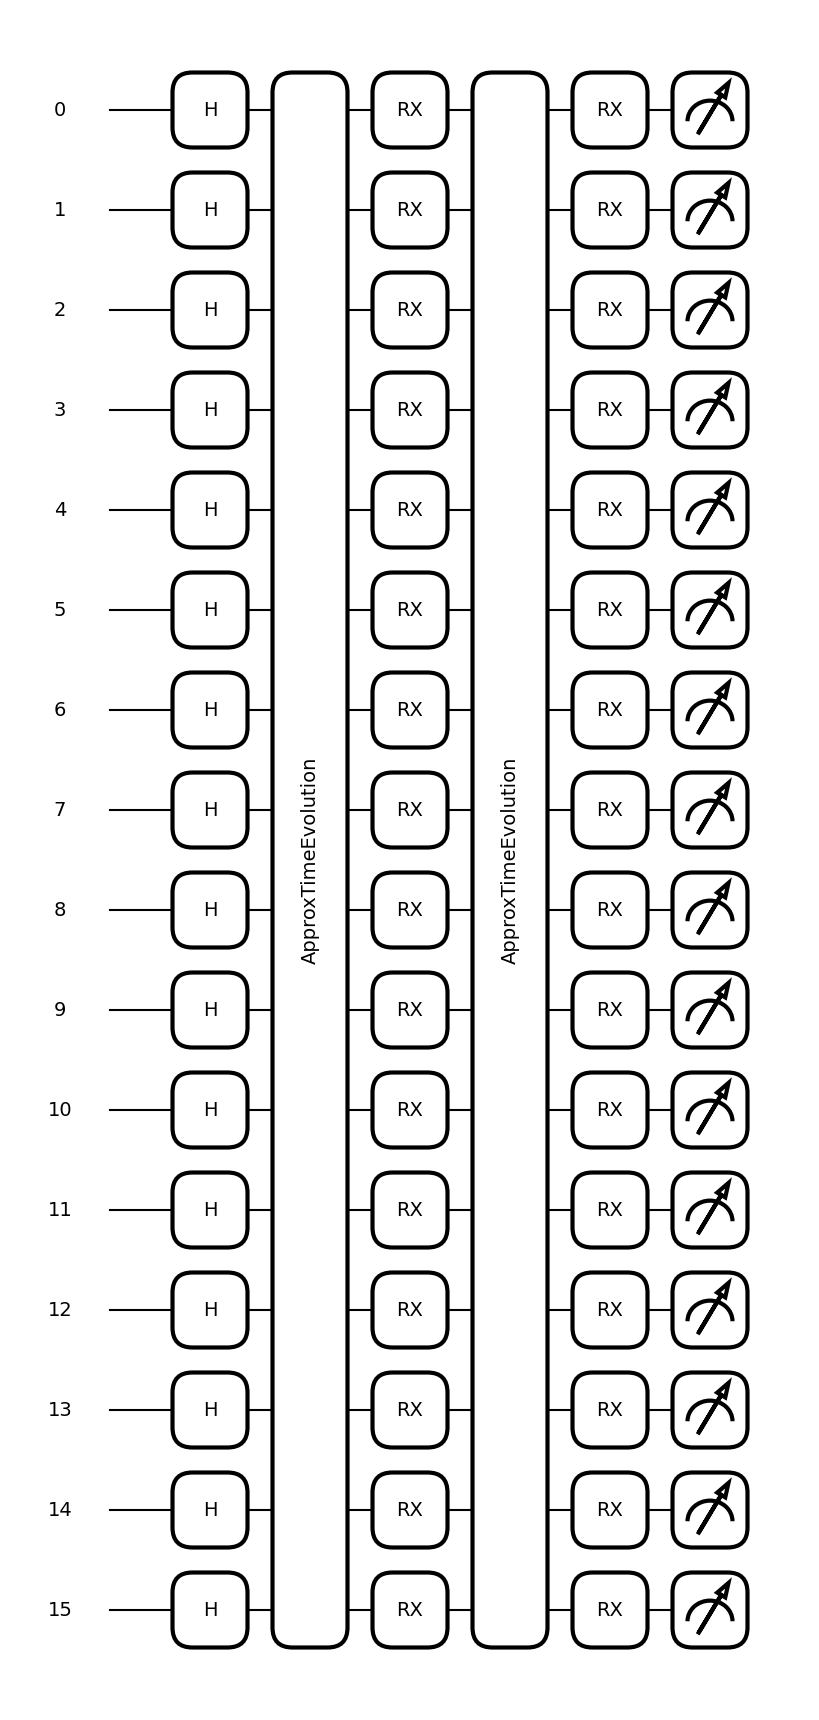

In [4]:
from pennylane.drawer import draw_mpl

draw_mpl(qaoa_circuit)(opt_params)

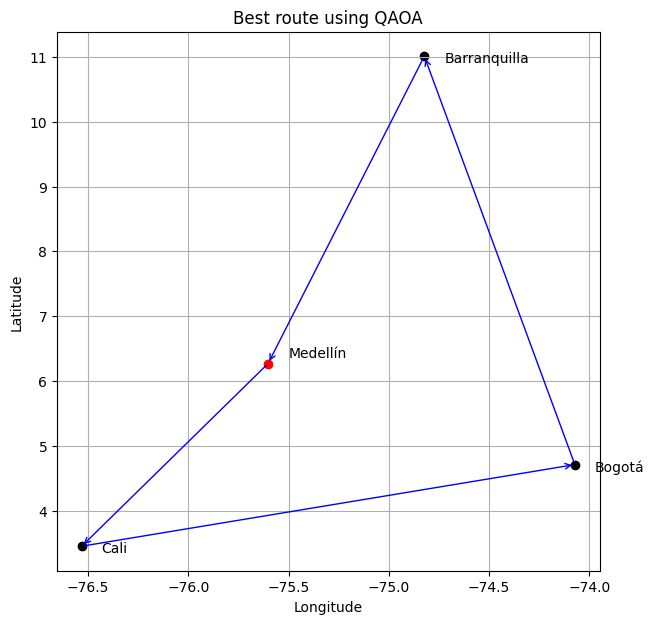

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the city names and their coordinates (fake sample data)
city_names = {0: 'Bogotá', 1: 'Medellín', 2: 'Cali', 3: 'Barranquilla'}
coordinates = {
    'Bogotá': {'Latitude': 4.711011, 'Longitude': -74.0720917},
    'Medellín': {'Latitude': 6.269732449999999, 'Longitude': -75.60255965090315},
    'Cali': {'Latitude': 3.4519988, 'Longitude': -76.5325259},
    'Barranquilla': {'Latitude': 11.0101922, 'Longitude': -74.8231794084391}
}

# Create a DataFrame with the city coordinates
df_cities = pd.DataFrame(coordinates).T

# Use the route from QAOA output
best_order = (1, 2, 0, 3)  # This is the route found by QAOA

# Draw the route on a map
plt.figure(figsize=(7, 7))

# Draw cities
for city, row in df_cities.iterrows():
    color = 'r' if city == 'Medellín' else 'black'
    dy = 0.1 if city == 'Medellín' else -0.1
    plt.scatter(row['Longitude'], row['Latitude'], c=color)
    plt.text(row['Longitude'] + 0.1, row['Latitude'] + dy, city, fontsize=10)

# Draw arrows for the route
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i in range(len(best_order)):
    start = city_names[best_order[i]]
    end = city_names[best_order[(i + 1) % len(best_order)]]
    plt.annotate(
        '', 
        xy=[df_cities.loc[end]['Longitude'], df_cities.loc[end]['Latitude']],
        xytext=[df_cities.loc[start]['Longitude'], df_cities.loc[start]['Latitude']],
        arrowprops=arrowprops
    )

plt.title('Best route using QAOA')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()
